# Goal: Align raw tiles to a stitched volume

## Step 0. Parameter setup

In [16]:
import h5py
import numpy as np
import os
import exm
import matplotlib.pyplot as plt
import tifffile
from exm.io import readXlsx, readNd2,tiles, readH5, writeH5, mkdir, tilesData,imAdjust
from exm.align import sitkTile, sitkTile2Volume


############# To change #############

## output files
Do = '/home/donglai/align/db/wormseq7/'

## input stitched volume
D0 = '/mp/nas3/WORMSeq7_Full3Rounds/WORMseq7_YoungAdult/'
align_method = 'terastitcher' # or bigstitcher
Ds = D0 + 'WORMseq7_YoungAdult_barcode3/Base3/output/'
# if bigstitcher
# fn_stitched = Ds + 'Stitched.h5'
# or terastitcher
# mip0: need to be h5
#fn_stitched_mip0 = Ds + 'RES(9854x5950x548)/000000/000000_000000/000000_000000_000040.tif'
fn_stitched_mip0 = Do + 'barcode3_hr.h5'
fn_stitched_mip2 = Do + 'barcode3_mip2.h5'
fn_stitched_lr = Ds + 'RES(1231x743x68)/000000/000000_000000/000000_000000_000040.tif'

## input tiles
fn_name = 'barcode5'
fn_tiles = D0 + 'WORMseq7_YoungAdult_%s/' % fn_name
fn_tiles_nd2 = fn_tiles + 'Channel405 SD_Seq0004.nd2' 
fn_tiles_channel = '405 SD'
fn_tiles_xlsx = fn_tiles + 'YoungAdult_%s_405.xlsx' % fn_name


## low-res registration
# threshold the range to change from uint16 to uint8
# do not rescale the tiles as some background tiles can be over-scaled
ratio_tiles_lr = [8,8,8]
ratio_stitched_lr = '3'
im_thres = [0, 255, False] 
#transform_type = 'affine'
transform_type = 'rigid' # good enough, more robust


############# No change #############
do_debug = True # for debug
Do = Do + '/'
mkdir(Do)
mkdir(Do + fn_name)
fn_out = Do + fn_name + '/'+ transform_type + '_%d-%d'

# save intermediate low-res results
if do_debug:
    mkdir(Do + 'lr/')
    
sn_stitched_lr = Do + 'lr/stitched_lr.h5'
sn_tiles_lr = Do + 'lr/%s_lr.h5' % fn_name
sn_transform_lr = Do + 'lr/%s_lr_%s.txt' % (fn_name, transform_type)
sn_tiles_warp_lr = Do + 'lr/%s_lr_%s_warped.h5' % (fn_name, transform_type)

## Step 1. Low-res volume-to-volume registration

### 1.1 Low-res stitched volume

In [17]:
# stithced volume is x [1,2,2] downsampled

# stitched resolution: stitching downsample x output scale
# [1,2,2] x [8,8,8]
# [3.2,2.6,2.6]

if align_method == 'bigstitcher':
    stitched_lr_h5 = h5py.File(fn_stitched, 'r')['t00000']['s00'][ratio_stitched_lr]['cells']
    stitched_hr_h5 = h5py.File(fn_stitched, 'r')['t00000']['s00']['0']['cells']
    if not os.path.exists(sn_stitched_lr):
        stitched_lr = imAdjust(np.array(stitched_lr_h5), [0,255,False])

    if do_debug:    
        writeH5(sn_stitched_lr, stitched_lr)
    else:
        stitched_lr = readH5(sn_stitched)

elif align_method == 'terastitcher':    
    stitched_hr_h5 = h5py.File(fn_stitched_mip0, 'r')['main']
    if not os.path.exists(sn_stitched_lr):
        stitched_lr = imAdjust(tifffile.imread(fn_stitched_lr), [0,255,False])
        writeH5(sn_stitched_lr, stitched_lr)
    else:
        stitched_lr = readH5(sn_stitched_lr)
    stitched_lr_h5 = h5py.File(sn_stitched_lr, 'r')['main']

In [18]:
if do_debug and False:
    # check out the image value distribution
    test = tifffile.imread(fn_stitched_lr)
    plt.hist(test[test>0])
    plt.yscale('log')

### 1.2 Low-res naive-stitch from xlsx

In [19]:
tiles_vol, tiles_info = readNd2(fn_tiles_nd2)
tiles_loc = readXlsx(fn_tiles_xlsx)


tiles_data = tilesData(tiles_vol, tiles_info, tiles_loc)
tiles_data.setChannel(fn_tiles_channel)
tiles_data.setRatio(ratio_tiles_lr)
tiles_data.setImThres(im_thres)

if not os.path.exists(sn_tiles_lr):
    tiles_lr = tiles_data.getTileRawStitch()
    
if do_debug:
    if not os.path.exists(sn_tiles_lr):
        writeH5(sn_tiles_lr, tiles_lr)
    else:
        tiles_lr = readH5(sn_tiles_lr)

exist 3 multipoint loops with length [4 4 9]
['405 SD']
volume size:  [ 482 9820 5969] (downsampled): [  61 1228  747]


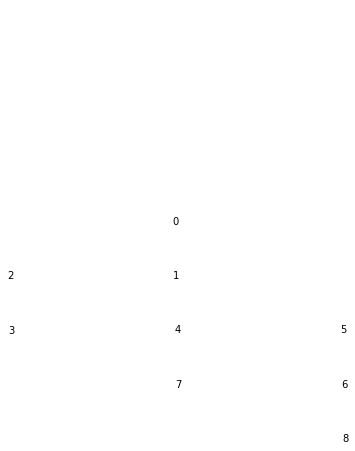

In [20]:
if do_debug:
    # display tile layout
    tiles_data.displayTileLoc()

In [21]:
if do_debug and False:
    # check out the image value distribution
    plt.hist(tiles_lr[tiles_lr>0])
    plt.yscale('log')

### 1.3 Compute registration

In [22]:
aligner = sitkTile()
# zyx -> xyz order
aligner.setResolution(tiles_data.getResolution(ratio_tiles_lr)[::-1])
aligner.setTransformType([transform_type], num_iteration=5000)


if not os.path.exists(sn_transform_lr):
    transform_lr = aligner.computeTransformMap(stitched_lr, tiles_lr,\
                                    mask_fix = (stitched_lr>0).astype(np.uint8),\
                                    mask_move = (tiles_lr>0).astype(np.uint8))
    if do_debug:
        aligner.writeTransformMap(sn_transform_lr, transform_lr)
else:
    transform_lr = aligner.readTransformMap(sn_transform_lr)

In [23]:
## debugging: visualization for napari
if do_debug and not os.path.exists(sn_tiles_warp_lr):
    tiles_lr_warp = aligner.warpVolume(tiles_lr, transform_lr).astype(np.uint8)
    writeH5(sn_tiles_warp_lr, tiles_lr_warp)

## [Optional: sanity check] Step 2. Low-res tile-to-volume alignment

In [24]:
do_check = False

if do_check:
    ### 2.1 Compute registration
    ratio_high = [8,8,8]; tmp_h5 = stitched_lr_h5
    #stitched_mip2_h5 = h5py.File(fn_stitched_mip2, 'r')['main']
    #ratio_high = [4,4,4]; tmp_h5 = stitched_mip2_h5

    aligner_t2s = sitkTile2Volume(tiles_data, tmp_h5, aligner, ratio_high)
    aligner_t2s.setInitialTransform(transform_lr)
    aligner_t2s.updateOutputSize(pad_ratio = 3)


    for tile_id in range(tiles_data.tiles_num):    
        if not os.path.exists(fn_out%(ratio_high[0], tile_id) + '.h5'):
            print(tile_id)
            aligner_t2s.alignTiles(tile_id, fn_out)


    ### 2.2 Render result        
    out = aligner_t2s.stitchTiles(fn_out, (50,512,512))        

## [Final result] Step 3. High-res tile-to-volume alignment

In [13]:
ratio_high = [1,1,1]; tmp_h5 = stitched_hr_h5

aligner_t2s = sitkTile2Volume(tiles_data, tmp_h5, aligner, ratio_high)
aligner_t2s.setInitialTransform(transform_lr)
aligner_t2s.updateOutputSize(pad_ratio = 3)

for tile_id in range(tiles_data.tiles_num):    
    if not os.path.exists(fn_out%(ratio_high[0], tile_id) + '.h5'):
        print(tile_id)
        aligner_t2s.alignTiles(tile_id, fn_out)

out = aligner_t2s.stitchTiles(fn_out, (50,512,512))

volume size:  [ 482 9820 5969] (downsampled): [ 483 9821 5970]
0


TypeError: not enough arguments for format string

In [14]:
fn_out

'/home/donglai/align/db/wormseq7//barcode5/rigid_%d-%d'